### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=0
uuid='eb6856a251bb8680da6593de98db7b5a'
timestamp='20170220T205506' # specify the date and time of the run in the format YYYYmmddTHHMMSS
run_dir=run_dir_prefix+timestamp
runfile='Exp_%s_run_%s.npz' % (uuid, run) # location of the experiment results
mdbn = MDBN.MDBN()
config, dbn_dict = mdbn.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 1.0],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [20],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'name': u'aml_config_20_1_05.json',
 u'p': 0.5,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

In [7]:
import utils
real_set, _ = utils.load_n_preprocess_data(datafiles['GE'],datadir=data_dir)

#### Compute the joint layer components

In [8]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

In [32]:
dbn_output = dbn_dict['GE'].get_output(theano.shared(np.zeros(real_set.get_value().shape,
                                                                        dtype=theano.config.floatX),borrow=True))
#dbn_output = np.zeros((real_set.get_value().shape[0],40),dtype=theano.config.floatX)

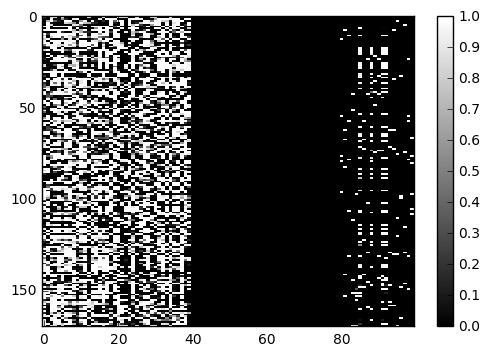

In [35]:
joint_layer = np.hstack((dbn_output_list[0],dbn_output,dbn_output_list[2]))
#joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

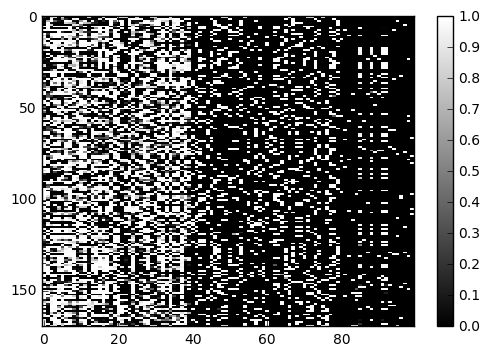

In [11]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [12]:
top_output = dbn_dict['top'].get_output(joint_layer)

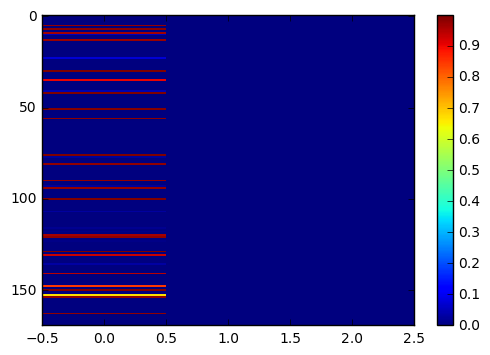

In [13]:
plt.imshow(top_output, interpolation='none')
plt.axis('tight')
plt.colorbar()

# Gibbs sampling of the top layer and prop down w/ ancestral sampling

We iterate the reconstruction 50 times

In [14]:
reload(rbm)

<module 'rbm' from '../src/rbm.pyc'>

In [15]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]

In [16]:
h1 = theano.tensor.matrix('h1')
rec_joint_layer = top_dbn_rbm0.sample_v_given_h(h1)
rec_joint_fn = theano.function([h1], rec_joint_layer)

In [130]:
for i in range(50):
    top_output = dbn_dict['top'].get_output(joint_layer)
    sampled_hidden_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True),gibbs_steps=50)
    sampled_joint_layer = rec_joint_fn(sampled_hidden_layer[0])
    joint_layer = np.concatenate([joint_layer[:,:40],sampled_joint_layer[2][:,40:80],joint_layer[:,80:100]],axis=1)

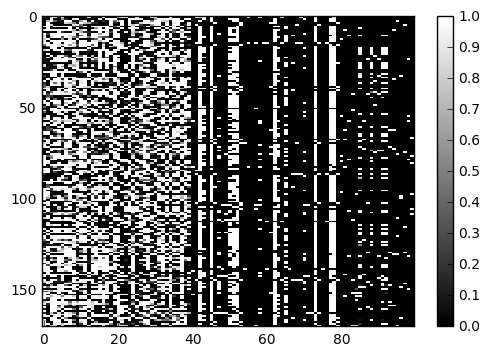

In [131]:
plt.imshow(joint_layer, cmap='gray',interpolation='none')
plt.axis('tight')
plt.colorbar()

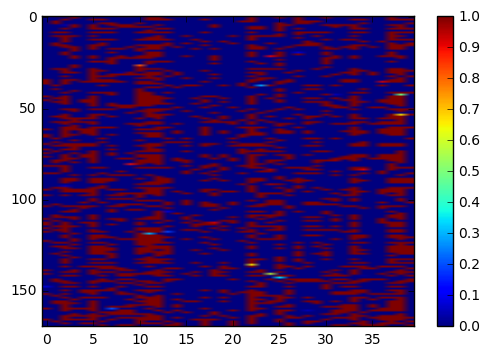

In [132]:
plt.imshow(np.sqrt(np.square(real_joint_layer[:,40:80]-joint_layer[:,40:80])))
plt.axis('tight')
plt.colorbar()

### Propagate down on the unimodal DBN

In [133]:
dbn_rbm1 = dbn_dict['GE'].rbm_layers[1]

In [134]:
sampled_hid_layer = dbn_rbm1.reverse_sampling(1,theano.shared(joint_layer[:,40:80],borrow=True))

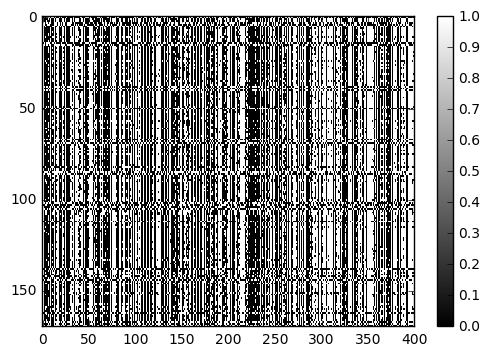

In [135]:
plt.imshow(sampled_hid_layer[0], interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [136]:
dbn_rbm0 = dbn_dict['GE'].rbm_layers[0]

In [137]:
vis_layer = dbn_rbm0.sample_v_given_h(h1)
vis_fn = theano.function([h1], vis_layer)

In [138]:
_, _, sampled_vis_layer = vis_fn(sampled_hid_layer[0])

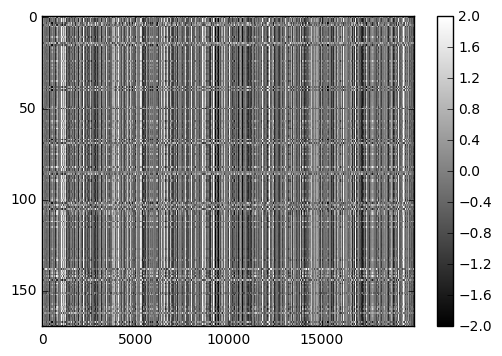

In [151]:
plt.imshow(sampled_vis_layer,interpolation='none',cmap='gray',clim=(-2,2))
plt.axis('tight')
plt.colorbar()

### Compare reconstructed and actual data

/Users/gluca/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 170 x 19937)
  '(shape is %d x %d)' % inp.shape[::-1])


([array([   0.,   24.,  127.,    1.,    2.,    8.,    2.,    6.,    0.,    0.]),
  array([   0.,    0.,    0.,    2.,  166.,    2.,    0.,    0.,    0.,    0.]),
  array([  0.,   0.,   0.,   8.,  11.,   4.,  12.,  36.,  99.,   0.]),
  array([   0.,    0.,    0.,   10.,  154.,    6.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,  141.,   11.,    3.,   10.,    5.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    8.,  159.,    2.,    1.,    0.,    0.,    0.]),
  array([   0.,    0.,    9.,    5.,    6.,  136.,   14.,    0.,    0.,    0.]),
  array([  1.,  10.,   2.,  83.,  21.,  30.,  20.,   0.,   3.,   0.]),
  array([   0.,    0.,    1.,   13.,  153.,    1.,    0.,    2.,    0.,    0.]),
  array([   0.,    0.,    2.,    5.,   24.,   34.,  105.,    0.,    0.,    0.]),
  array([  0.,   0.,   2.,   1.,  11.,  14.,  18.,  44.,  80.,   0.]),
  array([   0.,    0.,    1.,  150.,    2.,    3.,   11.,    3.,    0.,    0.]),
  array([   0.,    7.,    0.,  108.,   35.,   19.,    1., 

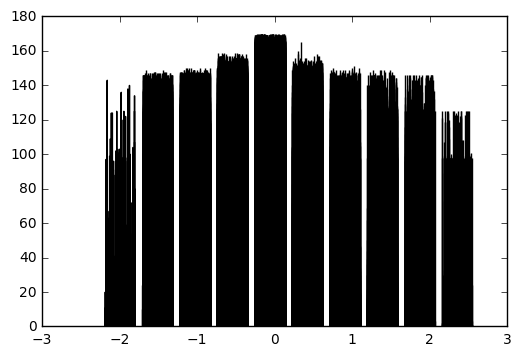

In [147]:
#plt.imshow(np.sqrt(np.square(real_set.get_value()-sampled_vis_layer)),interpolation='none')
#plt.axis('tight')
#plt.colorbar()
plt.hist(sampled_vis_layer)

([array([   0.,   17.,  113.,   36.,    4.,    0.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,  164.,    1.,    3.,    1.,    0.,    0.,    1.,    0.]),
  array([   0.,    0.,  154.,   13.,    2.,    0.,    0.,    0.,    1.,    0.]),
  array([   0.,    0.,  160.,    5.,    2.,    1.,    2.,    0.,    0.,    0.]),
  array([   0.,    1.,  141.,   21.,    5.,    2.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,  158.,    8.,    1.,    2.,    0.,    1.,    0.,    0.]),
  array([   0.,    0.,  156.,    9.,    3.,    0.,    2.,    0.,    0.,    0.]),
  array([   0.,   21.,  115.,   28.,    6.,    0.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,  149.,   15.,    4.,    2.,    0.,    0.,    0.,    0.]),
  array([   2.,   17.,  113.,   35.,    3.,    0.,    0.,    0.,    0.,    0.]),
  array([   0.,    1.,  146.,   18.,    3.,    1.,    1.,    0.,    0.,    0.]),
  array([   0.,   26.,  109.,   32.,    2.,    1.,    0.,    0.,    0.,    0.]),
  array([   0.,   25.,  111.

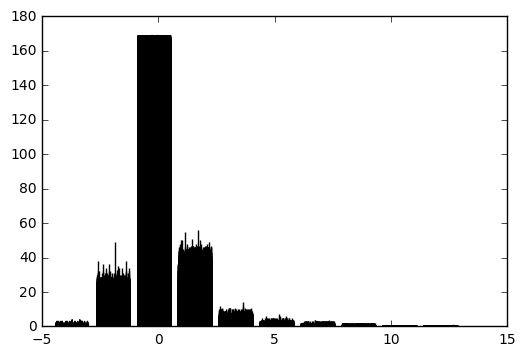

In [148]:
plt.hist(real_set.get_value())

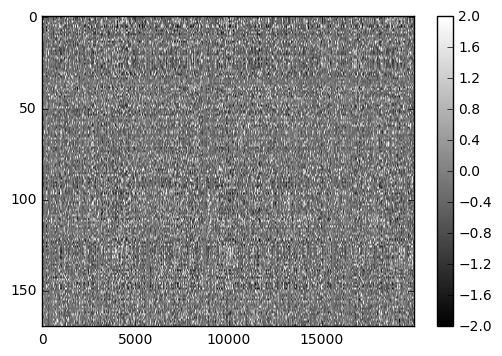

In [150]:
plt.imshow(real_set.get_value(),clim=(-2,2),cmap='gray')
plt.axis('tight')
plt.colorbar()

In [199]:
c = []
d = []
rss = 0
tss = 0
for i in range(170):
    rss = np.sum(np.square(real_set.get_value()[i]-sampled_vis_layer[i])[0])
    tss = np.sum(np.square(real_set.get_value()[i]-np.mean(real_set.get_value()[0]))[0])
    if rss/tss < 1.0:
        c.append(rss/tss)
    else:
        if rss/tss < 15.0:
            d.append(rss/tss)
        else:
            print i, rss/tss

36 57349.7
46 528.655
47 1084.54
55 309.552
66 17288.9
85 1608.88
99 1132.69
105 627.0
121 305.769
146 283.475
160 576.797
164 2786.27
165 51765.6


(array([ 21.,  12.,   9.,   3.,   3.,   0.,   4.,   1.,   1.,   2.]),
 array([  2.83354486e-04,   9.01190942e-02,   1.79954834e-01,
          2.69790574e-01,   3.59626313e-01,   4.49462053e-01,
          5.39297793e-01,   6.29133533e-01,   7.18969272e-01,
          8.08805012e-01,   8.98640752e-01]),
 <a list of 10 Patch objects>)

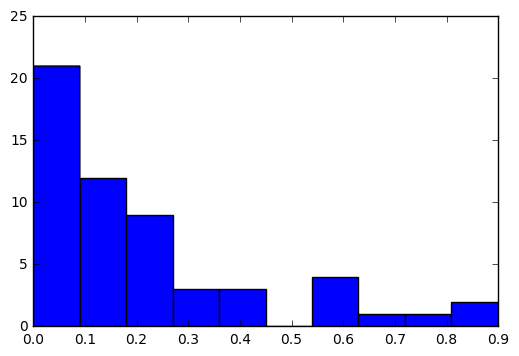

In [200]:
plt.hist(c)

In [201]:
np.mean(c)

0.21287887

In [206]:
len(c)

56

(array([ 16.,  14.,  15.,   8.,   5.,   2.,   3.,   4.,   2.,   3.]),
 array([  1.0114336 ,   2.18860731,   3.36578102,   4.54295473,
          5.72012844,   6.89730215,   8.07447586,   9.25164957,
         10.42882328,  11.60599699,  12.7831707 ]),
 <a list of 10 Patch objects>)

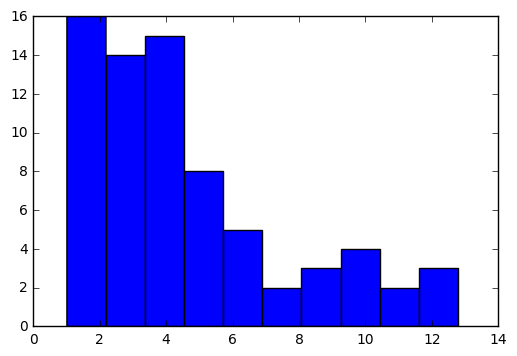

In [202]:
plt.hist(d)

In [203]:
np.mean(d)

4.6308947

In [204]:
len(d)

72